In [17]:
import os

train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"
classes = os.listdir(train_dir)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)

val_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
val_generator = val_datagen.flow_from_directory(
    valid_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)

test_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [19]:
import tensorflow
base_model = tensorflow.keras.applications.efficientnet.EfficientNetB4(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max'
)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras import regularizers
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(400, activation="softmax"))

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1792)              7168      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               205200    
Total params: 18,804,207
Trainable params: 18,675,416
Non-trainable params: 128,791
_________________________________________________________________


In [22]:
import tensorflow as tf
import time
class LRA(tf.keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch, csv_path=None):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # self.csv_path=csv_path
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.optimizers.Adam().lr.numpy()) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        self.data_dict={}
        for key in ['epoch','tr loss','tr acc','vloss','vacc','current lr','next lr','monitor','% improv','duration']:
            self.data_dict[key]=[]
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print(msg) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        # if self.csv_path !=None:
        #     df=pd.DataFrame.from_dict(self.data_dict)
        #     now = datetime.now() 
        #     year = str(now.year)
        #     month=str(now.month)
        #     day=str(now.day)
        #     hour=str(now.hour)
        #     minute=str(now.minute)
        #     sec=str(now.second)
        #     label = month + '-'+ day + '-' + year + '-' + hour + '-' + minute + '-' + sec +'.csv'
        #     csv_path=self.csv_path + '-'+ label
        #     df.to_csv(csv_path, index=False)
        #     print('training data saved as ', csv_path)

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs['accuracy']* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format('', str(batch), str(self.batches), acc, loss)
#         print(msg, end='\r') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs['val_loss']  # get the validation loss for this epoch
        acc=logs['accuracy']  # get training accuracy 
        v_acc=logs['val_accuracy']
        loss=logs['loss']        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                # color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    # color=(245, 170, 66)
                    lr*=self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count+=1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    elif v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss                                    
                else:
                    self.count+=1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                # color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    # color=(245, 170, 66)
                    lr*=self.factor # adjust the learning rate                    
                    self.stop_count+=1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count+=1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)
        key_list=['epoch','tr loss','tr acc','vloss','vacc','current lr','next lr','monitor','% improv','duration']
        val_list =[epoch + 1, loss, acc, v_loss, v_acc, current_lr, lr, monitor, pimprov, duration]
        for key, value in zip(key_list, val_list):
           self.data_dict[key].append(value)
        
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans=input('')                    
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    elif ans == 'T' or ans=='t':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print(msg)
                        msg='Enter an integer for the number of epochs to run then be asked again'
                        print(msg)
                        ans=int(input())
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch) 
                        print(msg)    
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg) 

In [23]:
import numpy as np
train_steps=int(np.ceil(len(train_generator.labels)/32))

In [24]:
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=20 # number of epochs to run before asking if you want to halt training
batches=train_steps
# csv_path=os.path.join(working_dir,'my_csv')
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold, factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=40, ask_epoch=ask_epoch)]

In [25]:
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_generator, epochs=40, callbacks=callbacks, validation_data=val_generator, shuffle=False
)

 initializing callback starting training with base_model trainable
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
1825/1825 [==============================] - 1290s 697ms/step - loss: 2.0857 - accuracy: 0.5625 - val_loss: 0.4809 - val_accuracy: 0.8800
 1 /40     2.086   56.246   0.48088  88.000   0.00100  0.00100  accuracy     0.00   1289.91 
Epoch 2/40
1825/1825 [==============================] - 1085s 594ms/step - loss: 0.9685 - accuracy: 0.7652 - val_loss: 0.3461 - val_accuracy: 0.9125
 2 /40     0.969   76.519   0.34609  91.250   0.00100  0.00100  accuracy    36.04   1084.72 
Epoch 3/40
1825/1825 [==============================] - 1094s 599ms/step - loss: 0.8219 - accuracy: 0.8019 - val_loss: 0.3718 - val_accuracy: 0.8940
 3 /40     0.822   80.188   0.37184  89.400   0.00100  0.00100  accuracy     4.79   1094.38 
Epoch 4/40
1825/1825 [==============================] - 1096s 600ms/step - loss: 0.7267 - accuracy: 0.8248 - val_lo

 5


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 21/40
1825/1825 [==============================] - 1080s 591ms/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 0.0635 - val_accuracy: 0.9875
21 /40     0.050   98.457   0.06354  98.750   0.00003  0.00002  val_loss    -7.71   1079.74 
Epoch 22/40
1825/1825 [==============================] - 1071s 587ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.0591 - val_accuracy: 0.9895
22 /40     0.051   98.397   0.05915  98.950   0.00002  0.00001  val_loss    -0.26   1070.86 
 training has been halted at epoch 22 after 3 adjustments of learning rate with no improvement
Training is completed - model is set with weights from epoch 19 
training elapsed time was 6.0 hours, 38.0 minutes, 58.33 seconds)


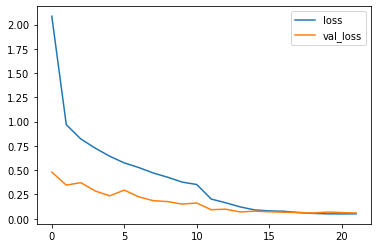

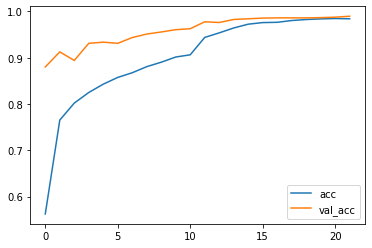

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

In [27]:
model.evaluate(test_generator)


63/63 [==============================] - 35s 549ms/step - loss: 0.0284 - accuracy: 0.9940


[0.028397297486662865, 0.9940000176429749]